In [30]:

import os
!pip install torch==2.0.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
#torch_version = '2.0.0+cu118'
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-${torch.__version__}.html
#!pip install torch-cluster -f https://data.pyg.org/whl/torch-${torch.__version__}.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-${torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install sentence-transformers
!pip install torcheval
!pip install matplotlib
!pip install pandas
!pip install tensorboard

Looking in indexes: https://download.pytorch.org/whl/cu118
2.0.0+cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-df5aao07
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-df5aao07
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit c3ea7ab4315149c3e5f80e1be68bca49598d4809
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [31]:
# if colab:
    # Install required packages.
    # !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    # !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    # !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    # !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install torch_geometric
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install sentence-transformers
# !pip install torcheval
# !pip install matplotlib
# !pip install pandas
# !pip install tensorboard

    # unpack datasets
    # if not 'unzipped' in globals():
    #     !unzip /content/drive/MyDrive/DataExplorationProject/Skill_Ontology_GNN/neo4jgraph.zip
    #     unzipped =True

In [32]:
import pandas as pd
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

In [33]:
# only use skill nodes which have normalized_name != NaN, this is some indication of quality skill (?)
skill_nodes = pd.read_csv('neo4jgraph/skills.csv').dropna(subset=['normalized_name']).reset_index()
job_nodes = pd.read_csv('neo4jgraph/onet_skills_unique.csv')

# drop some skills "or"
skill_nodes = skill_nodes.loc[~skill_nodes.skill.isin(['or','technology'])]

In [34]:
# There are duplicate normalized names
skill_nodes.shape[0]-skill_nodes.normalized_name.unique().shape[0]

38830

In [35]:
# There are not as many skill names which are duplicate
skill_nodes.shape[0]-skill_nodes.skill.unique().shape[0]

2488

In [36]:
# we can not use normalized name instead of skill, because it is ambiguous, e.g. communication points to different normalized names
skill_nodes.loc[skill_nodes.skill=='communication']

,index,skill,category,normalized_name
695,2229,communication,communication,Third-Party Provider Communication
1294,4059,communication,healthcare,Communication (Including SBAR)
4231,12919,communication,communication,Friendly Communication
5532,16927,communication,communication,radio/telephone communication
6315,19452,communication,communication,communication (phone and email)
...,...,...,...,...
223945,759817,communication,communication,Calling/Applying
224672,762531,communication,communication,Communication
238708,818822,communication,communication,Email/Phone Communication
245547,848577,communication,soft skills,Communication (Phone/Face-to-Face)


In [37]:
skill_nodes.drop_duplicates(subset='skill', inplace=True)

In [38]:

skill_job_edges = pd.read_csv('neo4jgraph/tfidf_skill_job_edge.csv')
#skill_job_edges = skill_job_edges.loc[skill_job_edges.scaled_tfidf>8]
# only use edges where we have the skill and job for from the other files
skill_job_edges = skill_job_edges.loc[skill_job_edges['skill'].isin(skill_nodes['skill'])]
skill_job_edges = skill_job_edges.loc[skill_job_edges['alt_title'].isin(job_nodes.index)]

In [39]:
skill_job_edges

,alt_title,skill,scaled_tfidf,n_jobdesc_used
1,55010,design,9.887307,240
5,55010,cg,8.744163,240
10,55010,visual effects,6.299518,240
11,55010,software,5.288013,240
12,55010,unity,5.278638,240
...,...,...,...,...
7926039,15285,analysis,6.147100,1
7926040,15285,software,6.013723,1
7926041,15285,engineering,5.864380,1
7926050,15285,development,4.434249,1


In [40]:
# map 3,6,7,3,3,... to 1,2,3,1,1 ...
skillmapping ={}
for i,skill in enumerate(skill_nodes.skill.unique()):
    skillmapping[skill] =i

jobmapping ={}
jobmapping_index_to_title_alttile = {}
for i, index in enumerate(job_nodes['index'].unique()):
    jobmapping[index] =i

for _, row in job_nodes.iterrows():
    if type(row['Title']) == str:
        a = row['Title']
    else:
        a = ''
    
    jobmapping_index_to_title_alttile[row['index']] = a+'/'+row['Alternate Title']

inverted_skillmapping = {v:k for k,v in skillmapping.items()}
inverted_jobmapping = {v:k for k,v in jobmapping.items()}

In [41]:
skill_job_edges['skill_dst'] = skill_job_edges['skill'].apply(lambda x:skillmapping[x])
skill_job_edges['job_src'] = skill_job_edges['alt_title'].apply(lambda x:jobmapping[x])

In [42]:
# normalization and removal of job-skill edges
# first group by jobs and limit the skills for each job to 175
# then normalize those tfidf edgeweights
# then group by skill and limit edges to 125 for skills (ordered by normalized tf-idf)
skill_job_edges = skill_job_edges.groupby('job_src').apply(lambda group: group.nlargest(175,'scaled_tfidf')).reset_index(drop=True)
summed_tfidf_per_job = skill_job_edges.groupby('job_src').sum()
skill_job_edges['sum'] = skill_job_edges['job_src'].apply(lambda x: summed_tfidf_per_job.loc[x]['scaled_tfidf'])
skill_job_edges['normalized_tfidf'] =  skill_job_edges['scaled_tfidf']/skill_job_edges['sum']
skill_job_edges = skill_job_edges.groupby('skill_dst').apply(lambda group: group.nlargest(125,'normalized_tfidf')).reset_index(drop=True)
# we dont do the second round of normalization

/tmp/ipykernel_9342/3367385361.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  summed_tfidf_per_job = skill_job_edges.groupby('job_src').sum()


In [43]:
# normalization and removing of skill-skill edges


In [44]:


#for each alt title select the first 125 skill_job edges, ordered by tfidf
# skill_job_edges = skill_job_edges.groupby('job_src')
# skill_job_edges = skill_job_edges.groupby('job_src').apply(lambda group: group.nlargest(125,'scaled_tfidf')).reset_index(drop=True)

# for each skill only use the 125 edges with the highest tf-idf score
#skill_job_edges = skill_job_edges.groupby('skill').apply(lambda group: group.nlargest(125,'scaled_tfidf')).reset_index(drop=True)

In [45]:
skill_job_edges

,alt_title,skill,scaled_tfidf,n_jobdesc_used,skill_dst,job_src,sum,normalized_tfidf
0,24372,working in shift,0.935676,25,3,24370,156.904865,0.005963
1,4357,working in shift,0.583803,103,3,4357,228.591855,0.002554
2,2930,digital creators,1.990591,103,6,2930,243.952632,0.008160
3,3119,digital creators,0.642614,47,6,3119,214.441921,0.002997
4,6300,integrated solutions,0.899847,13,11,6300,363.114154,0.002478
...,...,...,...,...,...,...,...,...
630681,158,company manuals,1.418798,10,247956,158,168.881625,0.008401
630682,30095,company manuals,0.486556,42,247956,30093,156.559067,0.003108
630683,6068,environmental inspection,1.265448,16,247957,6068,258.142721,0.004902
630684,14942,oilfield terminology,2.831527,6,247960,14940,311.253610,0.009097


In [46]:
onet_alttitles = pd.read_csv('neo4jgraph/onet_alt_titles_unique.csv')
del onet_alttitles['Unnamed: 0']

In [47]:
onet_alttitle_str_mapping = {}
for i,row in onet_alttitles.iterrows():
    onet_alttitle_str_mapping[row['index']] = row['Alternate Title']

In [48]:
import torch
mappings = {
    'onet_alttitle_str_mapping':onet_alttitle_str_mapping,
    'skillmapping':skillmapping,
    'inverted_skillmapping':inverted_skillmapping,
    'jobmapping':jobmapping,
    'inverted_jobmapping':inverted_jobmapping,
    'jobmapping_index_to_title_alttile':jobmapping_index_to_title_alttile
}

torch.save(mappings, 'Job_Skill_HeteroData_name_mappings_v3.pt')

In [49]:
from sentence_transformers import SentenceTransformer, util
embedder = SentenceTransformer('all-MiniLM-L6-v2')


False

In [73]:

# create alttitle sbert embeddings to get pca dim

jobtitle_sbert_embeddings = embedder.encode(list(onet_alttitle_str_mapping.values()), convert_to_tensor=False, device='cuda')
#alttitle_sbert_indices = [k for k,v in temp]
#corpus_embeddings = util.normalize_embeddings(corpus_embeddings)

In [ ]:
import numpy as np
v = alttitle_sbert_embeddings[0]
np.matmul(v.T,v)

0.99999994

In [ ]:
# get skill embeddings
skill_sbert_embeddings = embedder.encode(list(skillmapping.keys()), convert_to_tensor=False, device='cuda')

In [ ]:

from sklearn.decomposition import PCA
# concatenate skill and title embeddings for finding best pca
X = np.concatenate([alttitle_sbert_embeddings,skill_sbert_embeddings])

# print('Original:',X.shape[1])
# for variance_retained in [0.99,0.95,0.9,0.8,0.75,0.7]:
#     pca = PCA(n_components=variance_retained)
#     pca.fit(X)
#     n_components_retained = pca.n_components_
#     print(n_components_retained,' components retained', variance_retained, ' variance retained')

In [ ]:
job_nodes

,index,O*NET-SOC Code,Title,Alternate Title,Short Title,Source(s)
0,0,11-1011.00,Chief Executives,Aeronautics Commission Director,NaN,8
1,1,11-1011.00,Chief Executives,Agency Owner,NaN,10
2,2,11-1011.00,Chief Executives,Agricultural Services Director,NaN,8
3,3,11-1011.00,Chief Executives,Arts and Humanities Council Director,NaN,8
4,4,11-1011.00,Chief Executives,Bank President,NaN,9
...,...,...,...,...,...,...
55648,55652,55-3014.00,NaN,Artillery and Missile Crew Members,NaN,NaN
55649,55653,55-3015.00,NaN,Command and Control Center Specialists,NaN,NaN
55650,55654,55-3016.00,NaN,Infantry,NaN,NaN
55651,55655,55-3018.00,NaN,Special Forces,NaN,NaN


In [ ]:
# choose 128
pca = PCA(n_components=128)
pca.fit(X)

skill_sbert_embeddings = pca.transform(embedder.encode(skill_nodes['skill'].tolist(), convert_to_numpy=True, device='cuda'))
job_sbert_embeddings = pca.transform(embedder.encode(job_nodes['Alternate Title'].tolist(), convert_to_numpy=True, device='cuda'))

In [ ]:
# add job-job edges, dataset see https://www.onetcenter.org/dictionary/26.3/excel/related_occupations.html
job_job_edges = pd.read_csv('neo4jgraph/onet_related_occupations.csv')

In [ ]:
job_job_edges

,O*NET-SOC Code,Title,Related O*NET-SOC Code,Related Title,Relatedness Tier,index_x,index_y
0,11-1011.00,Chief Executives,11-1021.00,General and Operations Managers,Primary-Short,54641,54643
1,11-1031.00,Legislators,11-1021.00,General and Operations Managers,Supplemental,54644,54643
2,11-2021.00,Marketing Managers,11-1021.00,General and Operations Managers,Supplemental,54646,54643
3,11-2022.00,Sales Managers,11-1021.00,General and Operations Managers,Primary-Long,54647,54643
4,11-2032.00,Public Relations Managers,11-1021.00,General and Operations Managers,Primary-Long,54648,54643
...,...,...,...,...,...,...,...
18379,53-2022.00,Airfield Operations Specialists,53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Primary-Short,55590,55587
18380,53-2031.00,Flight Attendants,53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Supplemental,55591,55587
18381,53-5021.00,"Captains, Mates, and Pilots of Water Vessels",53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Primary-Short,55608,55587
18382,53-5022.00,Motorboat Operators,53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Supplemental,55609,55587


In [ ]:
job_job_edges['job_src'] = job_job_edges['index_x'].apply(lambda x: jobmapping[x])
job_job_edges['job_dst'] = job_job_edges['index_y'].apply(lambda x: jobmapping[x])
relatedness_weight = {
    'Supplemental':0.5,
    'Primary-Long':0.7,
    'Primary-Short':1
}
job_job_edges['relatedness_weight'] = job_job_edges['Relatedness Tier'].apply(lambda x: relatedness_weight[x])

In [ ]:
skill_skill_edges = pd.read_csv('neo4jgraph/skill_skill_edges.csv')


In [ ]:
#filter out potentially bad skills (which are not in our original skillmapping)
skill_skill_edges = skill_skill_edges.loc[(skill_skill_edges.skill.isin(list(skillmapping.keys()))) & (skill_skill_edges.related_skill.isin(list(skillmapping.keys())))]

In [ ]:
skill_skill_edges['skill_src'] = skill_skill_edges['skill'].apply(lambda x: skillmapping[x])
skill_skill_edges['skill_dst'] = skill_skill_edges['related_skill'].apply(lambda x: skillmapping[x])

In [ ]:
# only take largest 125 "both directions" (not ideal)
skill_skill_edges =  skill_skill_edges.groupby('skill_src').apply(lambda group: group.nlargest(125,'cosine_sim_score')).reset_index(drop=True)
skill_skill_edges =  skill_skill_edges.groupby('skill_dst').apply(lambda group: group.nlargest(125,'cosine_sim_score')).reset_index(drop=True)

In [ ]:
from torch_geometric.data import HeteroData
import torch

data = HeteroData()
data['Skill'].x = torch.tensor(skill_sbert_embeddings)
data['Job'].x = torch.tensor(job_sbert_embeddings)

data['Job','REQUIRES','Skill'].edge_index = torch.tensor(skill_job_edges[['job_src','skill_dst']].to_numpy().T)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index = torch.tensor(skill_skill_edges[['skill_src','skill_dst']].to_numpy().T)
data['Job','IS_SIMILAR_JOB','Job'].edge_index = torch.tensor(job_job_edges[['job_src','job_dst']].to_numpy().T)


data['Job','REQUIRES','Skill'].edge_weight = torch.tensor(skill_job_edges['normalized_tfidf'].to_numpy()).to(torch.float)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_weight = torch.tensor(skill_skill_edges['cosine_sim_score'].to_numpy()).to(torch.float)
data['Job','IS_SIMILAR_JOB','Job'].edge_weight = torch.tensor(job_job_edges['relatedness_weight'].to_numpy()).to(torch.float)

In [ ]:
skill_job_edges['normalized_tfidf'].min()

7.460347924957176e-06

In [ ]:
skill_skill_edges['cosine_sim_score'].min()

0.5

In [ ]:
job_job_edges['relatedness_weight'].min()

1

In [ ]:
data['Job'].x.shape

torch.Size([55653, 128])

In [ ]:
skill_skill_edges_temp = skill_skill_edges

In [ ]:
skill_skill_edges_temp.shape

(1273676, 7)

Jobs: 55653, actual Jobs used (in at least one edge): 16269
Skills: 247964, actual Skills used (in at least one edge): 120415

Following metrics only include Skills and Jobs with at least one edge:

JRS edges: 630686
Average JRS Job degree: 38.76612091064453, Skill: 5.237603187561035
Median JRS Job degree: 25.0, Skill: 4.0
Max JRS Job degree: 136.0, Skill: 125.0

S_SIM_S edges: 1039725
Average S_SIM_S degree: 17.269027709960938
Median S_SIM_S degree: 5.0
Max S_SIM_S degree: 250.0
J_SIM_J edges: 18384
Average J_SIM_J degree: 2.2600038051605225
Median J_SIM_J degree: 37.0
Max J_SIM_J degree: 126.0

Average total degree: Job: 41.026123046875
Average total degree: Skill: 22.50663185119629


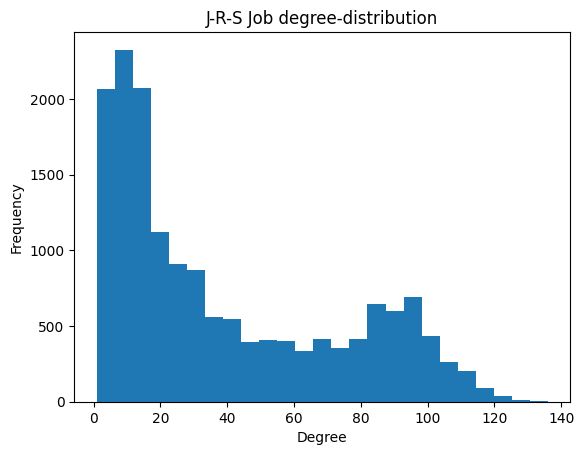

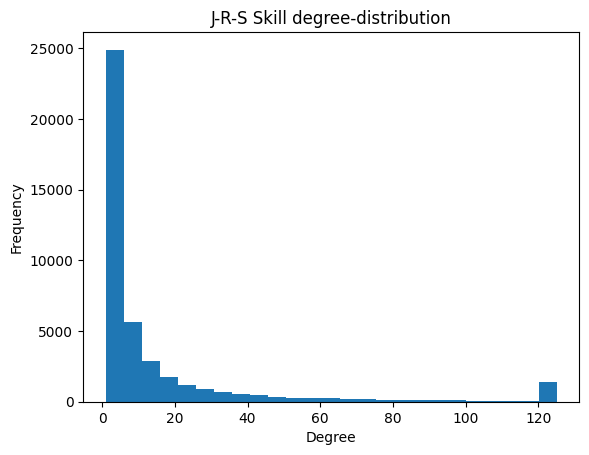

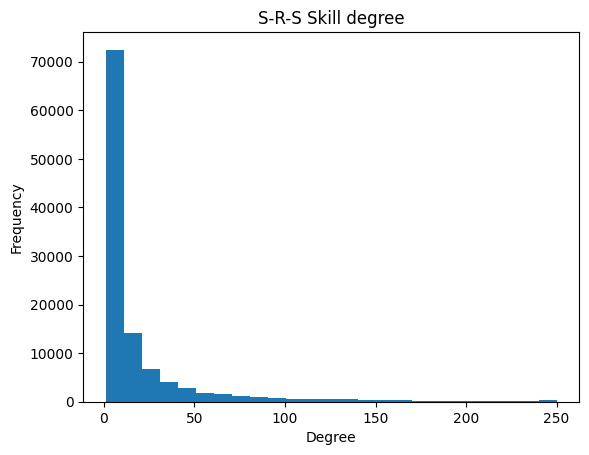

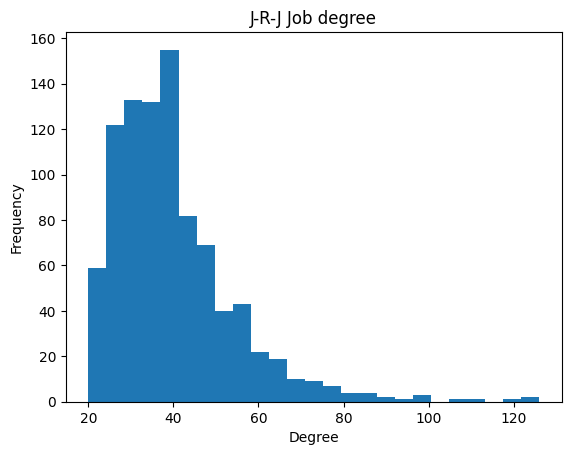

<Figure size 640x480 with 0 Axes>

In [ ]:
# Look at node degree statistics

from torch_geometric.utils import to_dense_adj, degree



job_n = data['Job'].x.shape[0]
skill_n = data['Skill'].x.shape[0]

JRS_J = degree(data['Job','REQUIRES','Skill'].edge_index[0], num_nodes=job_n)
JRS_S = degree(data['Job','REQUIRES','Skill'].edge_index[1], num_nodes=skill_n)
S_SIM_S = degree(data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index.flatten(), num_nodes=skill_n)
J_SIM_J = degree(data['Job','IS_SIMILAR_JOB','Job'].edge_index.flatten(), num_nodes=job_n)

actual_skill_n = torch.nonzero(JRS_S+S_SIM_S).shape[0] # only skills which have any edge at all
actual_job_n = torch.nonzero(JRS_J+J_SIM_J).shape[0] # only job which have any edge at all
print(f'Jobs: {job_n}, actual Jobs used (in at least one edge): {actual_job_n}')
print(f'Skills: {skill_n}, actual Skills used (in at least one edge): {actual_skill_n}')

print('\nFollowing metrics only include Skills and Jobs with at least one edge:\n')

print(f"JRS edges: {data['Job','REQUIRES','Skill'].edge_index.shape[1]}")
print(f'Average JRS Job degree: {torch.sum(JRS_J)/actual_job_n}, Skill: {torch.sum(JRS_S)/actual_skill_n}')
print(f'Median JRS Job degree: {torch.median(JRS_J[JRS_J!=0])}, Skill: {torch.median(JRS_S[JRS_S!=0])}')
print(f'Max JRS Job degree: {torch.max(JRS_J)}, Skill: {torch.max(JRS_S)}\n')

print(f"S_SIM_S edges: {data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index.shape[1]}")
print(f'Average S_SIM_S degree: {torch.sum(S_SIM_S)/actual_skill_n}')
print(f'Median S_SIM_S degree: {torch.median(S_SIM_S[S_SIM_S!=0])}')
print(f'Max S_SIM_S degree: {torch.max(S_SIM_S)}')

print(f'J_SIM_J edges: {data["Job", "IS_SIMILAR_JOB", "Job"].edge_index.shape[1]}')
print(f'Average J_SIM_J degree: {torch.sum(J_SIM_J)/actual_job_n}')
print(f'Median J_SIM_J degree: {torch.median(J_SIM_J[J_SIM_J!=0])}')
print(f'Max J_SIM_J degree: {torch.max(J_SIM_J)}\n')

print(f'Average total degree: Job: {(torch.sum(JRS_J)+torch.sum(J_SIM_J))/actual_job_n}')
print(f'Average total degree: Skill: {(torch.sum(JRS_S)+torch.sum(S_SIM_S))/actual_skill_n}')

import matplotlib.pyplot as plt
import os 

os.makedirs("plot_images/", exist_ok=True)

# Plot and save the first plot
plt.title('J-R-S Job degree-distribution')
plt.hist(JRS_J[JRS_J != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/JRS_J_degree_distribution.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

# Plot and save the second plot
plt.title('J-R-S Skill degree-distribution')
plt.hist(JRS_S[JRS_S != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/JRS_S_degree_distribution.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

# Plot and save the third plot
plt.title('S-R-S Skill degree')
plt.hist(S_SIM_S[S_SIM_S != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/S_SIM_S_skill_degree.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

# Plot and save the fourth plot
plt.title('J-R-J Job degree')
plt.hist(J_SIM_J[J_SIM_J != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/J_SIM_J_job_degree.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

In [ ]:
# Add features:
# - node degree
# - normalize edge weights by node degree
# - (triangle count)


# add node degree statistics:

job_degrees = torch.cat((JRS_J.reshape(-1,1) / 125, J_SIM_J.reshape(-1,1)/ 125), dim=1) # divide by approx. max degrees
skill_degrees = torch.cat((JRS_S.reshape(-1,1) / 125, S_SIM_S.reshape(-1,1)/ 125), dim=1) # divide by approx. max degrees

data['Job'].x = torch.cat((data['Job'].x, job_degrees), dim=1)
data['Skill'].x = torch.cat((data['Skill'].x, skill_degrees), dim=1)

# normalize edge weights by node degree

In [ ]:
from torch_sparse import SparseTensor
from tqdm.auto import tqdm
# adj_matmul
# row1 to rowS * full_matrix
# rowS+1 to rowT * full_matrix
# ....

# def blockwise_sparse_square_mmul(adj_matrix, blocks=None):
#     row_blocks = []
    
#     if blocks is None:
#         row_block_size = 10000
#         rows = adj_matrix.size(0)
#         for block in tqdm(range(0,rows, row_block_size), desc='blockwise sparse matrix-multiplication'):
#             start = block
#             end = min(block+row_block_size, rows)
#             row_blocks.append(adj_matrix[start:end].spspmm(adj_matrix))
#     else:
#         for block in tqdm(blocks, desc='blockwise sparse matrix-multiplication'):
#             row_blocks.append(block.spspmm(adj_matrix))

#     return row_blocks


# def blockwise_sparse_get_diag(blocks):
#     diags = []
#     for block in tqdm(blocks, desc='get blockwise sparse matrix diagonal'):
#         diags.append(get_diag(block))
    
#     return torch.cat(diags, dim=0)

def triangle_count(adj_matrix:SparseTensor):
    # adj_matmul, blockwise, so kernel does not crash
    # diag1((row1 to rowS) * full_matrix * full_matrix)
    # diag2((rowS+1 to rowR) * full_matrix * full_matrix)
    # ....
    diags = []
    
    row_block_size = 10000
    rows = adj_matrix.size(0)
    with torch.no_grad():
        for block in tqdm(range(0,rows, row_block_size), desc='blockwise sparse matrix-multiplication'):
            start = block
            end = min(block+row_block_size, rows)
            adj_pow_3_block = adj_matrix[start:end].spspmm(adj_matrix).spspmm(adj_matrix)
            diag_block = get_diag(adj_pow_3_block[:,start:])
            diags.append(diag_block)
            # diag = torch.eye(end)
            # indices_i, indices_j = diag.nonzero().unbind(dim=1)
            
            # A = adj_pow_2_block[indices_i]
            # B = adj_matrix[:, indices_j]
            # print(A, t(B))
            # print(type(B), type(A))
            # print(A.size(0), A.size(1), B.size(0), B.size(1))
            #C = A * t(B)
            #C = reduction(C, dim=1)
            
           
            #print(C)
            
            
            
    
    return 1/2 * torch.cat(diags, dim=0)
        
from torch_geometric.utils import to_undirected
from torch_sparse import SparseTensor
from torch_sparse.diag import get_diag

def undirected_triangle_counts(edge_index, max_num_nodes): 
    """Get triangles **per node**, to get count for whole graph, divide by 3"""
    ud = to_undirected(edge_index)
    
    adj_matrix = SparseTensor(row=ud[0], col=ud[1], value=torch.ones(ud[1].shape[0]), sparse_sizes=(max_num_nodes, max_num_nodes))
    #adj_matrix = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]), (max_num_nodes, max_num_nodes))
    #adj_matrix = torch.sparse_csr_tensor(ud[0], ud[1], values=torch.ones(ud[1].shape[0]), dtype=torch.float32).to_sparse_coo()
    triangles = triangle_count(adj_matrix) 
    return triangles

In [ ]:
# from torch_sparse import SparseTensor
# adj = torch.tensor(
#     [
#         [0,1,1,1,1],
#         [1,0,1,0,1],
#         [1,1,0,1,0],
#         [1,0,1,0,1],
#         [1,1,0,1,0]
#     ]
# ).to(torch.float)
# X = SparseTensor.from_dense(adj)
# triangles = triangle_count(X)
# triangles
#adj_matrix = SparseTensor(row=ud[0], col=ud[1], value=torch.ones(ud[1].shape[0]), sparse_sizes=(max_num_nodes, max_num_nodes))

blockwise sparse matrix-multiplication: 100%|██████████| 2/2 [00:00<00:00, 387.16it/s]

tensor([[8., 8., 8., 8., 8.],
        [8., 4., 8., 4., 8.],
        [8., 8., 4., 8., 4.]])
tensor([[8., 4., 8., 4., 8.],
        [8., 8., 4., 8., 4.]])


tensor([4., 2., 2., 2., 2.])

In [ ]:
homogeneous_data = data.to_homogeneous()
homogenous_triangles = undirected_triangle_counts(homogeneous_data.edge_index, homogeneous_data.x.shape[0])
# max triangles: 9000


blockwise sparse matrix-multiplication:   0%|          | 0/31 [00:00<?, ?it/s]/home/amos/mambaforge/envs/pyg/lib/python3.10/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  C = torch.sparse.mm(A, B)
blockwise sparse matrix-multiplication: 100%|██████████| 31/31 [08:04<00:00, 15.63s/it]


In [ ]:
Job_homogeneous_triangles = homogenous_triangles[homogeneous_data.node_type == 1]
Skill_homogeneous_triangles = homogenous_triangles[homogeneous_data.node_type != 1]

In [ ]:
actual_s_triangles = Skill_homogeneous_triangles[(JRS_S+S_SIM_S)!=0] 
actual_j_triangles = Job_homogeneous_triangles[(JRS_J+J_SIM_J)!=0] 

print(f'Median triangles of skill nodes: {actual_s_triangles.median()}, mean: {actual_s_triangles.mean()}, max: {actual_s_triangles.max()}, min: {actual_s_triangles.min()}')
print(f'Median triangles of job nodes: {actual_j_triangles.median()}, mean: {actual_j_triangles.mean()}, max: {actual_j_triangles.max()}, min: {actual_s_triangles.min()}')

Median triangles of skill nodes: 3.0, mean: 119.5722427368164, max: 9327.0, min: 0.0
Median triangles of job nodes: 6.0, mean: 35.92372131347656, max: 1316.0, min: 0.0


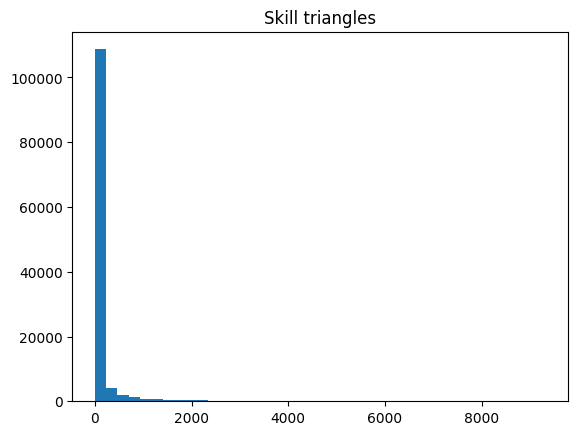

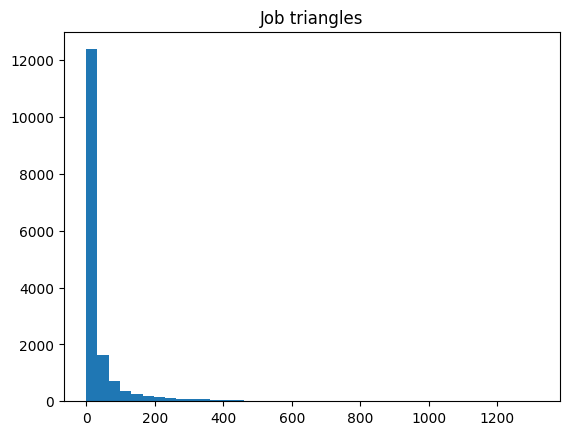

In [ ]:
plt.title('Skill triangles')
plt.hist(actual_s_triangles.numpy(), bins=40)
plt.show()
plt.title('Job triangles')
plt.hist(actual_j_triangles.numpy(), bins=40)
plt.show()

In [ ]:
J_SIM_J_triangles = undirected_triangle_counts(data['Job','IS_SIMILAR_JOB', 'Job'].edge_index, data['Job'].x.shape[0])
S_SIM_S_triangles = undirected_triangle_counts(data['Skill','IS_SIMILAR_SKILL', 'Skill'].edge_index, data['Skill'].x.shape[0])

blockwise sparse matrix-multiplication: 100%|██████████| 25/25 [02:27<00:00,  5.91s/it]


In [ ]:
actual_s_triangles = S_SIM_S_triangles[(JRS_S+S_SIM_S)!=0] 
actual_j_triangles = J_SIM_J_triangles[(JRS_J+J_SIM_J)!=0] 

print(f'Median triangles of skill nodes for skill-skill edges: {actual_s_triangles.median()}, mean: {actual_s_triangles.mean()}, max: {actual_s_triangles.max()}, min: {actual_s_triangles.min()}')
print(f'Median triangles of job nodes for job-job edges: {actual_j_triangles.median()}, mean: {actual_j_triangles.mean()}, max: {actual_j_triangles.max()}, min: {actual_s_triangles.min()}')

Median triangles of skill nodes for skill-skill edges: 2.0, mean: 113.15873718261719, max: 7185.0, min: 0.0
Median triangles of job nodes for job-job edges: 0.0, mean: 9.882168769836426, max: 1284.0, min: 0.0


In [ ]:
data['Skill'].x = torch.cat((data['Skill'].x, Skill_homogeneous_triangles.reshape(-1,1)/9285), dim=1) # normalize by max 9285.0
data['Job'].x = torch.cat((data['Job'].x, Job_homogeneous_triangles.reshape(-1,1)/1320), dim=1) # normalize by max 1320

data['Skill'].x = torch.cat((data['Skill'].x, S_SIM_S_triangles.reshape(-1,1)/9285), dim=1) # normalize by max 9285.0
data['Job'].x = torch.cat((data['Job'].x, J_SIM_J_triangles.reshape(-1,1)/1320), dim=1) # normalize by max 1320

In [ ]:
data.has_isolated_nodes(), data.has_self_loops()

(True, False)

In [ ]:
#data = data.to(device)

In [ ]:
import torch_geometric.transforms as T

transform = T.Compose([
       #T.RemoveIsolatedNodes(),
       T.RemoveDuplicatedEdges(),
       T.ToUndirected(merge=False) # don't merge reversed edges into the original edge type
])

data = transform(data)


In [ ]:
# torch.save(data.to_dict(), path)
# data = Data.from_dict(torch.load(path))

In [71]:
import os
import torch
from torch_geometric.data import HeteroData


filename = 'Job_Skill_HeteroData_v3.pt'
if os.path.exists('./'+filename):
    data = HeteroData.from_dict(torch.load('./'+filename))
    print('loading saved heterodata object')
else:
    torch.save(data.to_dict(), './'+filename)

loading saved heterodata object


In [73]:
from torch_geometric import seed_everything
import torch_geometric.transforms as T


transform = T.RandomLinkSplit(
    is_undirected=True,
    edge_types=[
        ('Job', 'REQUIRES', 'Skill'),
        ('Skill', 'IS_SIMILAR_SKILL', 'Skill'),
        ('Job', 'IS_SIMILAR_JOB', 'Job')
        ],
    rev_edge_types=[
        ('Skill', 'rev_REQUIRES', 'Job'),
        ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'),
        ('Job', 'rev_IS_SIMILAR_JOB', 'Job')
    ],
    num_val=0.005,
    num_test=0.01,
    add_negative_train_samples=False, # only adds neg samples for val and test, neg train are added by LinkNeighborLoader. This means for each train batch, negs. are different, for val and train they stay the same
    neg_sampling_ratio=1.0,
    disjoint_train_ratio=0, #  training edges are shared for message passing and supervision
    

    )

seed_everything(4)
train_data, val_data, test_data = transform(data)

In [4]:
# from torch_geometric.loader import NeighborLoader

# train_loader = NeighborLoader(
#     train_data,
#     # Sample 15 neighbors for each node and each edge type for 2 iterations:
#     num_neighbors={
#          ('Job', 'REQUIRES', 'Skill'):[1000,10], # [add x neighbors, add y neighbors for every x neighbor]
#          ('Skill', 'rev_REQUIRES', 'Job'):[10,0],
#         ('Skill', 'IS_SIMILAR_SKILL', 'Skill'):[10,10],
#         ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'):[0,0],
#         ('Job', 'IS_SIMILAR_JOB', 'Job'):[0,20], # can't sample job-job in first iteration
#         ('Job', 'rev_IS_SIMILAR_JOB', 'Job'):[0,20],
#          },
#     # num_neighbors = [10,10],
#     # Use a batch size of 128 for sampling training nodes of type "paper":
#     batch_size=200,
#     input_nodes='Job', #if not set, we consider all nodes
#     shuffle=True,
#     drop_last=True,
#     num_workers=4,
#     directed=True,  # contains only edges which are followed randomly, False: contains full node induced subgraph
# )


In [74]:
from typing import Tuple, List
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
from torch_geometric.data import HeteroData
import gc
import multiprocessing as mp


def create_loader(data:HeteroData, edge_type:Tuple[str,str,str], num_neighbors:List[int], negative_sampling_amount:int, batch_size:int, is_training:bool)->LinkNeighborLoader:

    #print('create mini-batches for', edge)

    negative_sampling = NegativeSampling(
        mode='binary',
        amount=negative_sampling_amount  # ratio, like Graphsage
        #weight=  # "Probabilities" of nodes to be sampled: Node degree follows power law distribution
        )
    num_workers = 2
    
    loader = LinkNeighborLoader(
        data,
        num_neighbors=num_neighbors,
        # {
        #     ('Job', 'REQUIRES', 'Skill'):num_neighbors,
        #     ('Skill', 'rev_REQUIRES', 'Job'):num_neighbors,
        #     ('Skill', 'IS_SIMILAR_SKILL', 'Skill'):num_neighbors, # In this example, index 0 will never be used, since neighboring edge to a job node can't be a skill-skill edge
        #     ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'):num_neighbors,
        #     ('Job', 'IS_SIMILAR_JOB', 'Job'):num_neighbors,
        #     ('Job', 'rev_IS_SIMILAR_JOB', 'Job'):num_neighbors,
        # },
        edge_label_index=(edge_type, data[edge_type].edge_label_index), # if (edge, None), None means all edges are considered
        #  =train_data[edge].edge_label,
        neg_sampling=negative_sampling, # adds negative samples
        batch_size=batch_size,
        shuffle=is_training,
        #drop_last=True,
        num_workers=num_workers,
        directed=True,  # contains only edges which are followed, False: contains full node induced subgraph
        #disjoint=True # sampled seed node creates its own, disjoint from the rest, subgraph, will add "batch vector" to loader output
        pin_memory=True, # faster data transfer to gpu
        #num_workers=2,
        #prefetch_factor=2
    )
    print(f'Using {num_workers} workers in the dataloader for edgetype {edge_type}')

    return loader


batch_size=64
num_neighbors = [5,4]

def create_iterator(data, is_training:bool):
    loaders = []
    supervision_edge_types = []
    for edge_type in [('Job', 'REQUIRES', 'Skill'),('Job', 'IS_SIMILAR_JOB', 'Job'), ('Skill', 'IS_SIMILAR_SKILL', 'Skill')]:
        # if 'rev_' in edge_type[1]:
        #     continue    
        # we dont need rev_ target edges, since they are the same
        # rev edges are only needed in the later step for the gnn traversal
        # create mini-batches for each edge type, because LinkNeighborLoader only allows one target edge type
     
        loader = create_loader(
            data=data,
            edge_type=edge_type,
            num_neighbors=num_neighbors,
            batch_size=batch_size,
            is_training=is_training,
            negative_sampling_amount=(20 if is_training else 1)
        )
        loaders.append(loader)
        supervision_edge_types.append(edge_type)
    
    
    # creates an iterator which has as many elements as the longest iterable
    # other iterables will be repeated until the longest is done
    length = 0
    index = 0
    for i, iterable in enumerate(loaders):
        l = len(iterable)
        if l>length:
            length = l
            index = i
            
 
    # for loader in loaders:
    #     minibatch = next(iter(loader))
        

    longest_loader = loaders.pop(index)
    longest_loader_edge_type = supervision_edge_types.pop(index)
    
   
    # create a list of iterators
    iterators = [iter(loader) for loader in loaders]
    
    def iterator():
        for batch in longest_loader:
            batches = [(longest_loader_edge_type,batch)]
            for i in range(len(iterators)):
                try:
                    batches.append((supervision_edge_types[i],next(iterators[i])))
                   
                except StopIteration:
                    iterators[i] = iter(loaders[i]) # will "reinit" iterator
                    batches.append((supervision_edge_types[i],next(iterators[i])))
                    
                    
            yield tuple(batches)

    return iterator, len(longest_loader)
    
    

# watch -n 1 df -h /dev/shm
gc.collect()
train_iterator, train_batch_len = create_iterator(train_data, is_training=True)
val_iterator, val_batch_len = create_iterator(val_data, is_training=False)
test_iterator, test_batch_len = create_iterator(test_data, is_training=False)

Using 2 workers in the dataloader for edgetype ('Job', 'REQUIRES', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'IS_SIMILAR_JOB', 'Job')
Using 2 workers in the dataloader for edgetype ('Skill', 'IS_SIMILAR_SKILL', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'REQUIRES', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'IS_SIMILAR_JOB', 'Job')
Using 2 workers in the dataloader for edgetype ('Skill', 'IS_SIMILAR_SKILL', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'REQUIRES', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'IS_SIMILAR_JOB', 'Job')
Using 2 workers in the dataloader for edgetype ('Skill', 'IS_SIMILAR_SKILL', 'Skill')


In [ ]:
# helpful article
# https://medium.com/stanford-cs224w/a-tour-of-pygs-data-loaders-9f2384e48f8f

# some info

# HeteroData(
#   Job={
#     x=[9222, 128], # node features
#     n_id=[9222] # the ids of the nodes in the original train_data set
#   },
#   (Job, REQUIRES, Skill)={
#     edge_index=[2, 14498], # sampled edges
#     edge_attr=[14498, 1],  # edge attributes of sampled edges
#     edge_label=[509170], # 1 if it is a true edge, 0 if it is a false
#     edge_label_index=[2, 509170], # all edges?
#     e_id=[14498] # edge ids of edges in the original train_data set



# if batchsize is 16 for the edge and we have neg_sampling=binary, we will have
# this many jobs:
#  Job={
#     x=[64, 128],
#     n_id=[64]
#   },
# since we sample a negative and a positive edge each, and each edge has 2 Job nodes (if our target is the job nodes)

# LinkNeighborloader will sample negative edges for the target edges only, as we expect it
# so for the "neighbor"-edges we get only positive ones

Implementing GraphSage Convolution, <br> see also https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/simple_conv.html#SimpleConv,<br> as well as  https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.SimpleConv.html#torch_geometric.nn.conv.SimpleConv

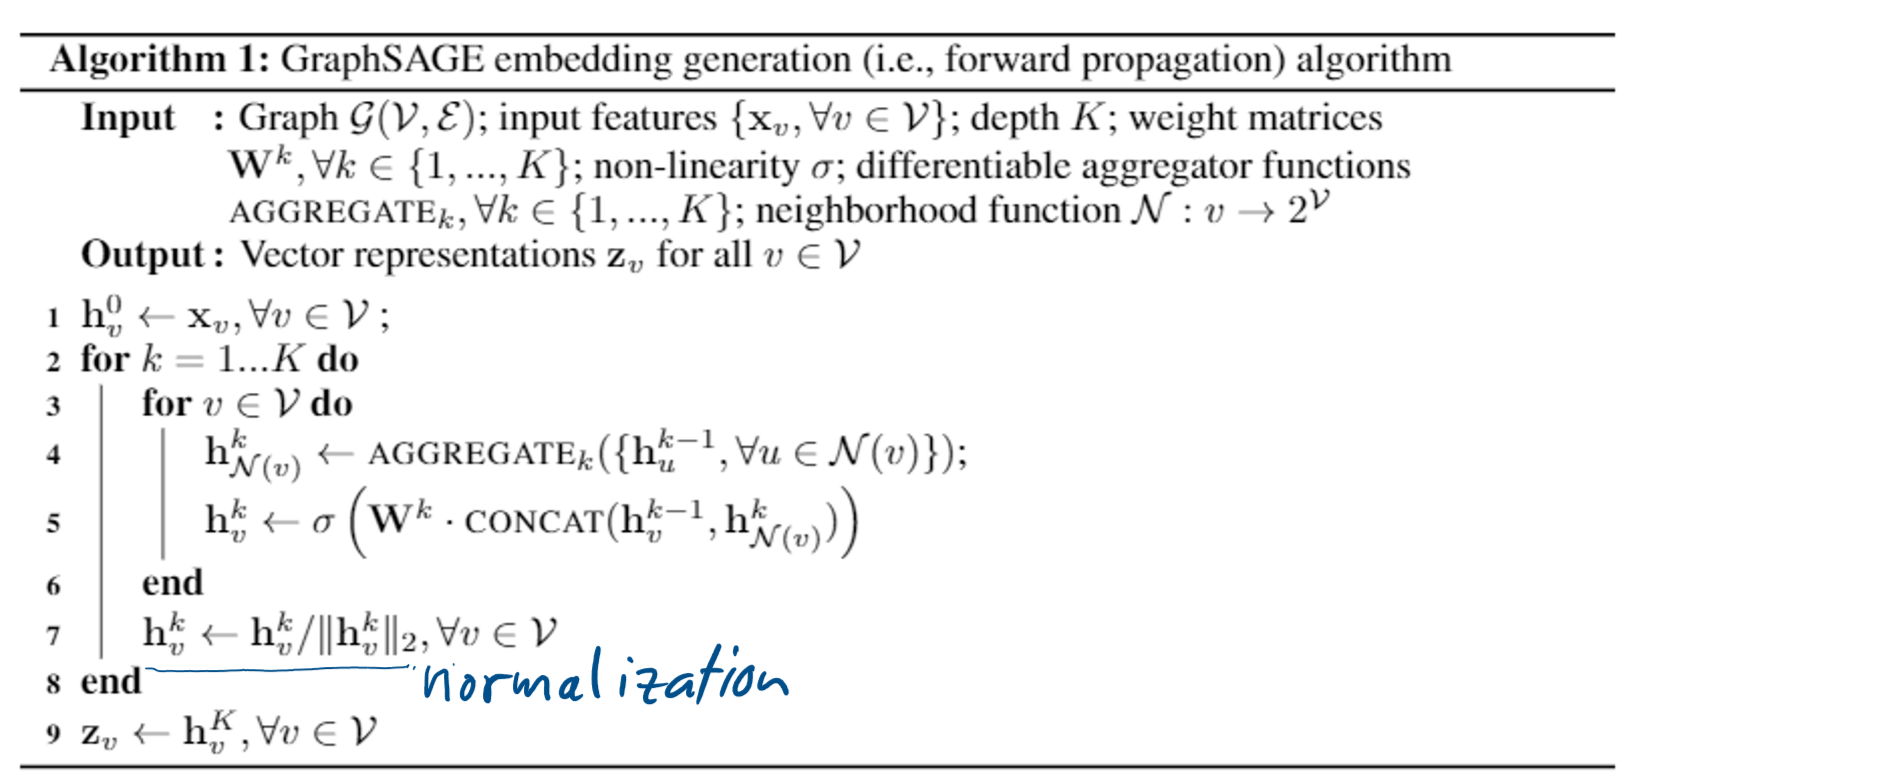

It is implemented in WeightedGraphSageConv using concatenation between h_v and h_n(v), like above.

The exact implementation is:
$$

x'_{i} =  \sigma (COMBINE(W_{i} \cdot x_{i},  W \cdot \text{AGGREGATE}\left(\left\{ h(x_{j}), \forall j \in N(j) \right\}\right))
 \quad \text(1))

$$
$$
h(x_{j}) = e_{ji} \cdot x_{i} \quad \text(2)

$$
$$
x'_{i} = \sigma (W \cdot \text{AGGREGATE}(\{x_{i}\}+\left\{ h(x_{j}), \forall j \in N(j) \right\}) \quad \text(3))
$$



Where COMBINE (1) is one of the following:
1. combine_root (str, optional) – Specifies whether or how to combine the central node representation (one of "sum", "cat"), cat will concatenate xi and the aggregation(xjs)

2. Can not be used in our case, because we have bipartite edges sometimes: self_loop as combination will consider xi like one of the xjs, see (3)

3. (2) includes the weight eji from node j to node i

AGGREGATION:
1. Mean, Max, Min, Sum, "max_pool" will do a relu(W_pool*xj) with the same weight before pooling

Notes: 
- if out_channels is 32 and COMBINE=Concatenation, then the 32 out channels will be split between xi (16) and agg(xjs) (16)

In [75]:
from torch_geometric.nn.conv import SimpleConv
from typing import List, Optional, Union

import torch
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.aggr import Aggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
    torch_sparse,
)
from torch_geometric.utils import add_self_loops, spmm

class WeightedGraphSageConv(SimpleConv):
    def __init__(self, in_channels: Union[int, Tuple[int, int]], out_channels: int, normalize, max_pool, combine_root: Optional[str] = None, aggr: str = 'add', bias: bool = True, **kwargs):
        super().__init__(aggr, combine_root, **kwargs)
        
        # from GraphConv https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/graph_conv.html#GraphConv
        self.in_channels = in_channels
        self.out_channels = out_channels

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
            
        if self.combine_root == 'cat':
            assert out_channels%2==0 and out_channels!=-1, 'number of in_channels must be even, and no lazy initialization (-1) is supported'
            to_out_channels = out_channels//2
        else:
            to_out_channels = out_channels
            
        self.lin_j_out = Linear(in_channels[0], to_out_channels, bias=bias)
        self.lin_i_out = Linear(in_channels[0], to_out_channels, bias=bias)
        self.lin_for_max_pool = Linear(in_channels[0], out_channels, bias=True)
        self.normalize = normalize
        self.max_pool = max_pool
        self.reset_parameters()
        
    def reset_parameters(self):
        super().reset_parameters()
        self.lin_j_out.reset_parameters()
        self.lin_i_out.reset_parameters()
        self.lin_for_max_pool.reset_parameters()
    
    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_weight: OptTensor = None, size: Size = None) -> Tensor:

        if self.combine_root is not None:
            if self.combine_root == 'self_loop':
                if not isinstance(x, Tensor) or (size is not None
                                                 and size[0] != size[1]):
                    raise ValueError("Cannot use `combine_root='self_loop'` "
                                     "for bipartite message passing")
                if isinstance(edge_index, Tensor):
                    edge_index, edge_weight = add_self_loops(
                        edge_index, edge_weight, num_nodes=x.size(0))
                elif isinstance(edge_index, SparseTensor):
                    edge_index = torch_sparse.set_diag(edge_index)

        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        if self.max_pool:
            x = (self.lin_for_max_pool(x[0]).relu(), x[1])
        # propagate_type: (x: OptPairTensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=size)

        x_dst = x[1]
        if x_dst is not None and self.combine_root is not None and self.combine_root!='self_loop':
            x_dst = self.lin_i_out(x_dst)
            out = self.lin_j_out(out)
            if self.combine_root == 'sum':
                out = out + x_dst
            elif self.combine_root == 'cat':
                out = torch.cat([x_dst, out], dim=-1)
        
        out = torch.relu(out)
        
        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)
        return out


# Sage conv from the paper, max pooling would be
# normalize will set length
# you can choose to pass edgeweights, then it wont be exactly as in the paper
conv = WeightedGraphSageConv(256, 256, normalize=True, combine_root='cat', aggr='max', bias=True, max_pool=True)

In [13]:
# from torch_geometric.nn.conv import GraphConv, SAGEConv, SimpleConv, HeteroConv
# hidden_channels = 10


# c = SimpleConv(aggr='sum',combine_root='cat')


# skill_skill = SimpleConv(aggr='sum',combine_root='cat')  # use same for rev_skill as well
# job_job = SimpleConv(aggr='sum',combine_root='cat') # use same for rev_job... as well


# conv = HeteroConv(
#                 {
#                     ('Job', 'REQUIRES', 'Skill'): SimpleConv(aggr='sum',combine_root='cat'),
#                     ('Skill', 'rev_REQUIRES', 'Job'): SimpleConv(aggr='sum',combine_root='cat'),
#                     ('Skill', 'IS_SIMILAR_SKILL', 'Skill'): skill_skill,
#                     ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'):skill_skill,
#                     ('Job', 'IS_SIMILAR_JOB', 'Job'):job_job,
#                     ('Job', 'rev_IS_SIMILAR_JOB', 'Job'):job_job,
#                 }, aggr='cat')

# conv(a.x_dict, a.edge_index_dict, a.edge_weight_dict)['Skill'].shape

In [83]:
from typing import Tuple, Union
from torch import Tensor
import torch
import torch_geometric
from torch_geometric.nn import to_hetero, HeteroDictLinear, Linear
from torch_geometric.nn.conv import GraphConv, SAGEConv, SimpleConv, HeteroConv

from torch_geometric.typing import Adj, OptPairTensor, OptTensor, Size
from torch_geometric import seed_everything
from torch_geometric.utils import trim_to_layer

class WeightedSkillSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, n_conv_layers):
        super().__init__()
        
        self.lin_in = torch.nn.ModuleDict({
            'Skill': Linear(in_channels,hidden_channels),
            'Job': Linear(in_channels,hidden_channels)
        })
        
        
      
        
        self.hetero_convs = torch.nn.ModuleList()
        for i in range(n_conv_layers):
            # if i == n_conv_layers-1:
            #     in_ch = (in_channels, in_channels)
            # else:
            in_ch = (hidden_channels, hidden_channels)
                
            skill_skill = WeightedGraphSageConv(in_ch, hidden_channels, normalize=True, max_pool=True, combine_root='cat', aggr='max', bias=True)  # use same for rev_skill as well
            job_job = WeightedGraphSageConv(in_ch, hidden_channels, normalize=True, max_pool=True, combine_root='cat', aggr='max', bias=True)  # use same for rev_job... as well
            conv = HeteroConv(
                {
                    ('Job', 'REQUIRES', 'Skill'): WeightedGraphSageConv(in_ch, hidden_channels, normalize=True, max_pool=True, combine_root='cat', aggr='max', bias=True),
                    ('Skill', 'rev_REQUIRES', 'Job'): WeightedGraphSageConv(in_ch, hidden_channels, normalize=True, max_pool=True, combine_root='cat', aggr='max', bias=True),
                    ('Skill', 'IS_SIMILAR_SKILL', 'Skill'):skill_skill,
                    ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'):skill_skill,
                    ('Job', 'IS_SIMILAR_JOB', 'Job'):job_job,
                    ('Job', 'rev_IS_SIMILAR_JOB', 'Job'):job_job,
                }, aggr='sum')
            self.hetero_convs.append(conv)
            
        self.lin_out = torch.nn.ModuleDict({
            'Skill': Linear(hidden_channels, out_channels),
            'Job': Linear(hidden_channels, out_channels)
        })

    def forward(self, x_dict, edge_index_dict, edge_weight_dict, num_sampled_edges_dict, num_sampled_nodes_dict):
        x_dict = {key: F.relu(self.lin_in[key](x)) for key, x in x_dict.items()}
        
        # speedup: only compute necessary node representations in each pass through https://pytorch-geometric.readthedocs.io/en/latest/advanced/hgam.html
        for i, conv in enumerate(self.hetero_convs):
            x_dict, edge_index_dict, edge_weight_dict = trim_to_layer(
                layer=i,
                num_sampled_nodes_per_hop=num_sampled_nodes_dict, 
                num_sampled_edges_per_hop=num_sampled_edges_dict, # gives the num sampled edges per edge type, e.g. ('Job', 'REQUIRES', 'Skill'): [3083, 14514] -> 3000 in first step, 14000 in second
                x=x_dict,
                edge_index=edge_index_dict,
                edge_attr=edge_weight_dict
            )
        
            x_dict = conv(x_dict, edge_index_dict, edge_weight_dict) # edge_weight_dict
            # x_dict = {key: F.relu(x) for key, x in x_dict.items()} # relu already implemented
            
        
        x_dict = {key: F.relu(self.lin_out[key](x)) for key, x in x_dict.items()}
        return x_dict

seed_everything(14)
model = WeightedSkillSAGE(in_channels=132, hidden_channels=256, out_channels=256, n_conv_layers=2)
#model = to_hetero(model, train_data.metadata(), aggr='sum')
model =  torch_geometric.compile(model, dynamic=True, fullgraph=False)


/home/amos/mambaforge/envs/pyg/lib/python3.10/site-packages/torch_geometric/compile.py:28: UserWarning: Could not convert the 'model' into a jittable version. As such, 'torch.compile' may currently fail to correctly optimize your model. 'MessagePassing.jittable()' reported the following error: source code not available
  warnings.warn(JIT_WARNING.format(error=e))


In [67]:
from typing import Tuple, Union
from torch import Tensor
import torch
import torch_geometric
from torch_geometric.nn import to_hetero, HeteroDictLinear, Linear
from torch_geometric.nn.conv import GraphConv, SAGEConv, SimpleConv, HeteroConv

from torch_geometric.typing import Adj, OptPairTensor, OptTensor, Size
from torch_geometric import seed_everything
from torch_geometric.utils import trim_to_layer

class WeightedSkillGraphConv(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        
        self.lin_in = torch.nn.ModuleDict({
            'Skill': Linear(132,hidden_channels),
            'Job': Linear(132,hidden_channels)
        })
        
        
        
        self.hetero_convs = torch.nn.ModuleList()
        for _ in range(2):
            skill_skill = GraphConv((-1, -1), hidden_channels)  # use same for rev_skill as well
            job_job = GraphConv((-1, -1), hidden_channels)  # use same for rev_job... as well
            conv = HeteroConv(
                {
                    ('Job', 'REQUIRES', 'Skill'): GraphConv((-1, -1), hidden_channels),
                    ('Skill', 'rev_REQUIRES', 'Job'): GraphConv((-1, -1), hidden_channels),
                    ('Skill', 'IS_SIMILAR_SKILL', 'Skill'):skill_skill,
                    ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'):skill_skill,
                    ('Job', 'IS_SIMILAR_JOB', 'Job'):job_job,
                    ('Job', 'rev_IS_SIMILAR_JOB', 'Job'):job_job,
                }, aggr='sum')
            self.hetero_convs.append(conv)
            
        self.lin_out = torch.nn.ModuleDict({
            'Skill': Linear(hidden_channels, out_channels),
            'Job': Linear(hidden_channels, out_channels)
        })

    def forward(self, x_dict, edge_index_dict, edge_weight_dict, num_sampled_edges_dict, num_sampled_nodes_dict):
        x_dict = {key: F.relu(self.lin_in[key](x)) for key, x in x_dict.items()}
        
        # speedup: only compute necessary node representations in each pass through https://pytorch-geometric.readthedocs.io/en/latest/advanced/hgam.html
        for i, conv in enumerate(self.hetero_convs):
            x_dict, edge_index_dict, edge_weight_dict = trim_to_layer(
                layer=i,
                num_sampled_nodes_per_hop=num_sampled_nodes_dict, 
                num_sampled_edges_per_hop=num_sampled_edges_dict, # gives the num sampled edges per edge type, e.g. ('Job', 'REQUIRES', 'Skill'): [3083, 14514] -> 3000 in first step, 14000 in second
                x=x_dict,
                edge_index=edge_index_dict,
                edge_attr=edge_weight_dict
            )
        
            x_dict = conv(x_dict, edge_index_dict, edge_weight_dict) # edge_weight_dict
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
            
        
        x_dict = {key: F.relu(self.lin_out[key](x)) for key, x in x_dict.items()}
        return x_dict

seed_everything(14)
model = WeightedSkillGraphConv(hidden_channels=256, out_channels=256)
#model = to_hetero(model, train_data.metadata(), aggr='sum')
#model =  torch_geometric.compile(model)

In [78]:
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAUPRC, BinaryAUROC
from tqdm.auto import tqdm
import gc
from torch.utils.tensorboard import SummaryWriter
import os
from pathlib import Path
from datetime import datetime
import torch
import numpy as np
from sklearn.metrics import f1_score


class GNNTrainer():
    def __init__(self, model, criterion, optimizer, device, log_folder):
        #super().__init__(model, criterion, optimizer, device, ) # metrics=['f1','accuracy','precision','recall', 'aucpr']
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_batch_size = 0  # for tqdm, for logging
        self.train_n_mini_in_batch = 0  # for tqdm
        self.val_n_mini_in_batch = 0  # for tqdm
        self.log_folder = log_folder
    
    def free_memory(self):
        """Clears the GPU cache and triggers garbage collection, to reduce OOMs."""
        torch.cuda.empty_cache()
        gc.collect()
        
    
            
    
        
    def write_calc_metrics(self, split_name:str, y_hat, y, y_per_edgetype, y_hat_per_edgetype, epoch:int, is_epoch:bool, minibatch:int=0, loss:int=0, loss_per_edgetype=None, print_=True):
        assert epoch>=1, 'Epoch must be >= 1'
        assert minibatch >= 1, "minibatch must be >=1"
        
        if split_name=='train':
            assert self.train_batch_size != 0
            assert self.train_n_mini_in_batch != 0
            assert loss != 0, "loss can't be 0"
            if is_epoch:
                loss_per_edge_type = {}
                y_per_edgetype = {}
                y_hat_per_edgetype = {}
            assert loss_per_edgetype is not None
            
        else:
            assert loss_per_edgetype is None
            
        if is_epoch:
            split_name = 'epoch_'+split_name
            index = epoch
        else:
            split_name = 'samples_'+split_name
            no_minibatches = (epoch-1)*self.train_n_mini_in_batch + minibatch
            approx_no_samples = no_minibatches*self.train_batch_size
            index = approx_no_samples
        
        y_per_edgetype[('','all','')]= y
        y_hat_per_edgetype[('','all','')]= y_hat
        if 'train' in split_name:
            loss_per_edgetype[('','all','')] = loss
        
        
        for edgetype in y_per_edgetype.keys():
            y = y_per_edgetype[edgetype].to(torch.int).detach().cpu()
            y_hat = y_hat_per_edgetype[edgetype].detach().cpu()
            edge_name = '-'.join(list(edgetype)).strip('-')
        
            
            def calculate_f1(y_hat, y, thresholds):
                
                return np.array([f1_score(y_hat>threshold, y, average='binary') for threshold in thresholds])
            
            # get best f1 threshold
            thresholds = np.arange(0.001, 1, 0.001)
            a, b = y_hat.numpy(), y.numpy()
            f1s = calculate_f1(a,b , thresholds)
            optimal_threshold = thresholds[np.argmax(f1s)]
            f1=max(f1s)
    
            acc, prec, rec = BinaryAccuracy(threshold=optimal_threshold).update(y_hat, y).compute().item(), BinaryPrecision(threshold=optimal_threshold).update(y_hat, y).compute().item(), BinaryRecall(threshold=optimal_threshold).update(y_hat, y).compute().item()
            self.writer.add_scalar(f'{split_name}_f1threshold_{edge_name}', optimal_threshold, index)
            self.writer.add_scalar(f'{split_name}_accuracy_{edge_name}', acc, index)
            self.writer.add_scalar(f'{split_name}_precision_{edge_name}', prec, index)
            self.writer.add_scalar(f'{split_name}_recall_{edge_name}', rec, index)
            self.writer.add_scalar(f'{split_name}_f1_{edge_name}', f1, index)
            
        
            auprc = BinaryAUPRC().update(y_hat, y).compute().item()
            auroc = BinaryAUROC().update(y_hat, y).compute().item()
            
            self.writer.add_scalar(f'{split_name}_auprc_{edge_name}', auprc, index)
            self.writer.add_scalar(f'{split_name}_auroc_{edge_name}', auroc, index)
            if 'train' in split_name:
                loss = loss_per_edgetype[edgetype]
                self.writer.add_scalar(f'{split_name}_loss_{edge_name}', loss, index)
            self.writer.flush()
            
            if print_ and edgetype==('','all',''):
                out_of = f'/{self.train_n_mini_in_batch:06d}' if 'train' in split_name else ''
                no_samples = f'|samples:{index}' if 'train' in split_name else ''
                loss_to_show = f'loss:{loss:.4f},' if 'train' in split_name else ''
                print(f'{split_name}|{int(minibatch):04d}{out_of}|{epoch:04d}{no_samples}|{loss_to_show} F1: {f1:.6f}, AUC-PR: {auprc:.6f}, (auroc: {auroc:.6f}, acc: {acc:.6f}, prec: {prec:.6f}, rec: {rec:.6f})')

    def create_logfolders(self, run_folder=None):
        if run_folder is None:
            run_folder = datetime.now().strftime('run_%d%m%Y_%H%M%S')
            
        self.writer = SummaryWriter(log_dir=Path(self.log_folder)/(run_folder+'_tensorboard'))
        self.checkpoint_folder = Path(self.log_folder)/(run_folder+'_checkpoints')
        if not os.path.exists(self.checkpoint_folder):
            os.makedirs(self.checkpoint_folder)
        
        if not os.path.exists(Path(self.log_folder)/(run_folder+'_tensorboard')):
            os.makedirs(Path(self.log_folder)/(run_folder+'_tensorboard'))
            
        print(f'run folder is {run_folder}')
        
    
    def train(self, train_iterator, val_iterator, start_epoch, n_epochs, run_folder=None, save_metrics_after_n_batches=100):
        self.free_memory()
        self.create_logfolders(run_folder)

        self.model.train()
        assert start_epoch >= 1, "Epoch must be >= 1"
        
        for epoch in range(start_epoch, start_epoch+n_epochs):
            
            epoch_loss = 0
            for batch_idx, edge_batches in tqdm(enumerate(train_iterator()), total=self.train_n_mini_in_batch, desc='train epoch'):
                batch_idx+=1  # start from 1
                self.optimizer.zero_grad()  # empty gradients
                minibatch_loss = 0
                loss_per_edgetype = {}
                y_hat, y = [], []
                y_hat_per_edgetype, y_per_edgetype = {}, {}
                for supervision_edge_type, batch in edge_batches:  # each "batch" here is one edge type, since we want to learn for all edge types
                    batch = batch.to(self.device)
                    hetero_out = model(batch.x_dict, batch.edge_index_dict, batch.edge_weight_dict, batch.num_sampled_edges_dict, batch.num_sampled_nodes_dict)  # get model output

                    # evaluate, calculate cosine sim and compute cross-entropy loss
                    src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
                    edge_label = batch[supervision_edge_type].edge_label
                    edge_label_index = batch[supervision_edge_type].edge_label_index
                    src_node_embeddings = hetero_out[src_type][edge_label_index[0]]
                    dst_node_embeddings = hetero_out[dst_type][edge_label_index[1]]
                    
                    loss, y_pred = self.criterion(src_node_embeddings, dst_node_embeddings, edge_label)
                    
                    minibatch_loss += loss
                    # collect data for metrics
                    loss_per_edgetype[supervision_edge_type] = loss.detach().item()
                    y_hat_per_edgetype[supervision_edge_type] = y_pred.detach().cpu()
                    y_per_edgetype[supervision_edge_type] = edge_label.to(torch.int).detach().cpu()
                    y_hat.append(y_hat_per_edgetype[supervision_edge_type])
                    y.append(y_per_edgetype[supervision_edge_type])
                    
                minibatch_loss.backward()
                self.optimizer.step()
                minibatch_loss = minibatch_loss.detach().item()
                epoch_loss += minibatch_loss
             
                y_hat = torch.cat(y_hat)
                y = torch.cat(y)
                # create metrics and write to tensorboard writer
                if batch_idx%save_metrics_after_n_batches==1:
                    self.write_calc_metrics('train', y_hat, y, y_per_edgetype, y_hat_per_edgetype,  epoch=epoch, minibatch=batch_idx, loss=minibatch_loss, loss_per_edgetype=loss_per_edgetype, is_epoch=False, print_=False)
                    self.validate(val_iterator, epoch, batch_idx, is_epoch=False)
                    self.model.train()  # back to training, just in case
           
            self.save_checkpoint(epoch, batch_idx)
            self.write_calc_metrics('train', y_hat, y, y_per_edgetype={}, y_hat_per_edgetype={}, loss_per_edgetype={}, epoch=epoch, minibatch=batch_idx, loss=epoch_loss, is_epoch=True, print_=True)
            self.validate(val_iterator, epoch, batch_idx, is_epoch=True)
            self.model.train()  # back to training, just in case
            
    def validate(self, val_iterator, epoch, batch_idx, is_epoch):
        self.model.eval()
        with torch.no_grad():
            y_hat, y = [], []
            y_hat_per_edgetype, y_per_edgetype = {}, {}
            for edge_batches in val_iterator():
                for supervision_edge_type, batch in edge_batches:  # each "batch" here is one edge type, since we want to learn for all edge types
                    batch = batch.to(self.device)
                    hetero_out = model(batch.x_dict, batch.edge_index_dict, batch.edge_weight_dict, batch.num_sampled_edges_dict, batch.num_sampled_nodes_dict)

                    # evaluate, calculate cosine sim and compute cross-entropy loss
                    src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
                    edge_label = batch[supervision_edge_type].edge_label
                    edge_label_index = batch[supervision_edge_type].edge_label_index
                    if src_type not in  hetero_out.keys() or dst_type not in hetero_out.keys():
                        print('eval failed on one minibatch part, skipping')
                        print('Supervision edge type:',supervision_edge_type)
                        print('one type is missing in model output',src_type, dst_type)
                        print(batch.x_dict)
                        print(hetero_out.keys())
                        print(batch)
                        continue
                        
                    src_node_embeddings = hetero_out[src_type][edge_label_index[0]]
                    dst_node_embeddings = hetero_out[dst_type][edge_label_index[1]]
                    
                    #logits = F.cosine_similarity(src_node_embeddings, dst_node_embeddings, dim=-1)
                    
                    _, y_pred = self.criterion(src_node_embeddings, dst_node_embeddings, edge_label)
                    # y_hat.append(y_pred.detach())
                    # y.append(edge_label.to(torch.int).detach())

                    # collect data for metrics
                    if supervision_edge_type not in y_hat_per_edgetype.keys():
                        y_hat_per_edgetype[supervision_edge_type] = []
                        y_per_edgetype[supervision_edge_type] = []
                        
                    y_hat_per_edgetype[supervision_edge_type].append(y_pred.detach().cpu())
                    y_per_edgetype[supervision_edge_type].append(edge_label.to(torch.int).detach().cpu())
                   
                    
            # save metrics
            for key in y_hat_per_edgetype:
                y_hat_per_edgetype[key] = torch.cat(y_hat_per_edgetype[supervision_edge_type])
                y_per_edgetype[key] = torch.cat(y_per_edgetype[supervision_edge_type])
                y_hat.append(y_hat_per_edgetype[key])
                y.append(y_per_edgetype[key])
                
            y_hat = torch.cat(y_hat)
            y = torch.cat(y)
            self.write_calc_metrics('val', y_hat, y, y_per_edgetype, y_hat_per_edgetype, epoch=epoch, is_epoch=is_epoch, print_=True, minibatch=batch_idx)
    
    def save_checkpoint(self, epoch, batch_idx):
        print(f'save checkpoint {self.checkpoint_folder}/checkpoint_ep{epoch}_{batch_idx}.pt')
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
           # 'metrics_history': self.story,
        }, f'{self.checkpoint_folder}/checkpoint_ep{epoch}.pt')

    def load_checkpoint(self, load_path):
        checkpoint = torch.load(load_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [85]:
import os
import torch
#os.environ["TOKENIZERS_PARALLELISM"] = "true"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
torch._dynamo.config.verbose=True
torch._dynamo.config.suppress_errors = True

optimizer = torch.optim.Adam(model.parameters(), lr=2e-7) #2e-15
def graphSAGE_loss(u, v, y_label):
    y_neg = (y_label-1)
    y_label = (y_neg + y_label).squeeze()  # has -1 for neg and 1 for pos
    # loss= -1* log(sig(u,v_pos)) - Q*E*log(sig(-1*u,v_neg)) where Q is number of neg, E is expected value
    logits = torch.sum(torch.mul(u, v), dim=-1)
    
    mul = torch.sigmoid(torch.mul(logits, y_label))
    loss = -1*torch.sum(torch.log(mul)) # sum across all examples
    y_hat = torch.sigmoid(logits) # just for metrics in later step
    return loss, y_hat.detach()

criterion = graphSAGE_loss
#criterion = torch.nn.CrossEntropyLoss()
trainer = GNNTrainer(model, criterion, optimizer, device , log_folder='runs')
#trainer.load_checkpoint('./checkpoints/checkpoint_0_300.pt')


# for tqdm
trainer.train_batch_size = batch_size
trainer.train_n_mini_in_batch = train_batch_len
trainer.val_n_mini_in_batch = val_batch_len

trainer.train(
    train_iterator, 
    val_iterator, 
    start_epoch=1, 
    n_epochs=200, 
    run_folder=f'temp', # WeightedSkillSAGE_lr_2emin7_1lin_1lin_256dim_edgeweight
    save_metrics_after_n_batches=1000) # graphconv_v0_lr_2emin6_2lin_1lin_256dim
# trainer.validate(val_dataloader)
# trainer.plot_losses()
# trainer.load_checkpoint('./checkpoints/checkpoint_100.pt')
# trainer.validate(val_iterator,1)



run folder is temp


train epoch:   0%|          | 0/16003 [00:00<?, ?it/s][2023-10-09 15:15:53,654] torch._dynamo.convert_frame: [ERROR] WON'T CONVERT <graph break in forward> /home/amos/mambaforge/envs/pyg/lib/python3.10/site-packages/torch_geometric/nn/conv/hetero_conv.py line 119 
119           0 LOAD_FAST                0 (___stack0)
              2 JUMP_ABSOLUTE            5 (to 10)
              4 LOAD_GLOBAL              0 (defaultdict)
              6 LOAD_GLOBAL              1 (list)
              8 CALL_FUNCTION            1
        >>   10 STORE_FAST               6 (out_dict)

120          12 LOAD_FAST                3 (edge_index_dict)
             14 LOAD_ATTR                2 (items)
             16 CALL_FUNCTION            0
             18 GET_ITER
        >>   20 FOR_ITER               192 (to 406)
             22 UNPACK_SEQUENCE          2
             24 STORE_FAST               7 (edge_type)
             26 STORE_FAST               8 (edge_index)

121          28 LOAD_FAST            

KeyboardInterrupt: 

In [ ]:
#tensorboard --logdir=runs
#http://localhost:6006 

9803.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.14.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
# 1440057
# 1407132.

In [ ]:
490586.58532714844
485814.1606140137
474801.0126953125

In [ ]:
# ep100, Loss: 757468.5991210938
# Loss: 739222.503692627
# oss: 737091.7985534668
#Loss: 734385.8401489258
# 732283.552154541

In [ ]:
supervision_edge_type = get_supervision_edge_type(batch)
src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
edge_label = batch[supervision_edge_type].edge_label
edge_label_index = batch[supervision_edge_type].edge_label_index
src_node_embeddings = out[src_type][edge_label_index[0]]
dst_node_embeddings = out[dst_type][edge_label_index[1]]
torch.min(F.cosine_similarity(src_node_embeddings, dst_node_embeddings, dim=-1))

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
batch[supervision_edge_type].edge_label_index

In [ ]:
J2S = ('Job','REQUIRES','Skill')
batch[J2S].edge_label_index

In [ ]:
batch['Job','REQUIRES','Skill'].

In [ ]:
batch = next(iter(train_loaders[0]))


In [ ]:
batch

In [ ]:
batch.edge_weight_dict

In [ ]:
index = batch['Job','IS_SIMILAR_JOB','Job'].e_id
labels = batch['Job','IS_SIMILAR_JOB','Job'].edge_label

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(-1, hidden_channels)
        self.conv2 = SAGEConv(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64, out_channels=dataset.num_classes)
model = to_hetero(model, data.metadata(), aggr='sum')

In [ ]:
#https://colab.research.google.com/drive/1GrAxHyZCZ13jpTkMy9vVO_v_U9nHDdvB#scrollTo=wmiFKI0ovYN4


In [ ]:
# intially we use this GraphConv layer and aggregate using mean
# this layer allows the addition of edge weights: the adjacency matrix simply consists not of 1s and 0s but the corresponding weights
#https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GraphConv.html

# using max pool
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_max_pool.html#torch_geometric.nn.pool.global_max_pool